<a href="https://colab.research.google.com/github/Melsonwang1/CVNL-assignment/blob/main/RNN%20Trained%20using%20emotion%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/My\ Drive/Colab\ Notebooks/
!ls
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from idlmam  import *

Mounted at /content/drive
drive  sample_data


/content/drive/My Drive/Colab Notebooks/idlmam.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [29]:
import unicodedata
import string
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

print("importing the relevant modules")

importing the relevant modules


In [10]:
!pip install datasets

print("download dataset to import it later on")

download dataset to import it later on


In [13]:
from datasets import load_dataset

# Load the Emotion dataset
dataset = load_dataset("emotion")

# Check the dataset structure
print(dataset)

# Correct key to access the labels
label_mapping = dataset["train"].features["label"].names
print(label_mapping)  # List of all emotion labels


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [18]:
import string
import unicodedata
from datasets import load_dataset

# Initialize the emotion_data dictionary
emotion_data = {}

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {all_letters[i]: i for i in range(n_letters)}

# Define function to normalize text
def unicodeToAscii(s):
    """Turns a Unicode string into plain ASCII."""
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in all_letters
    )

# Load the Emotion dataset
dataset = load_dataset("emotion")

# Corrected: Building the emotion_data dictionary
print("\nBuilding emotion_data from dataset...\n")
for sample in dataset["train"]:  # Loop through the training data
    text = sample["text"]  # The text sample
    labels = sample["label"]  # The label for this sample

    # Normalize the text using the unicodeToAscii function
    normalized_text = unicodeToAscii(text).lower()

    # Use the correct 'labels' variable for mapping
    emotion = label_mapping[labels]  # Map label index to emotion name

    # Add to the emotion_data dictionary
    if emotion not in emotion_data:
        emotion_data[emotion] = []  # Initialize the list for this emotion
    emotion_data[emotion].append(normalized_text)

# Print out the emotion names and their respective text count before removing
print("\nEmotion counts before removing samples:")
for emotion, texts in emotion_data.items():
    print(f"{emotion}: {len(texts)} samples")

# Remove 12,000 "neutral" samples
if "neutral" in emotion_data:
    num_samples_to_remove = 12000
    if len(emotion_data["neutral"]) >= num_samples_to_remove:
        emotion_data["neutral"] = emotion_data["neutral"][:-num_samples_to_remove]  # Remove 12,000 samples
        print(f"\nRemoved 12,000 neutral samples. Remaining neutral samples: {len(emotion_data['neutral'])}")
    else:
        print(f"\nNot enough neutral samples to remove. Only {len(emotion_data['neutral'])} available.")
else:
    print("\nNo 'neutral' samples found in the dataset.")

# Print out the updated emotion names and their respective text count after removal
print("\nEmotion counts after removing samples:")
for emotion, texts in emotion_data.items():
    print(f"{emotion}: {len(texts)} samples")



Building emotion_data from dataset...


Emotion counts before removing samples:
sadness: 4666 samples
anger: 2159 samples
love: 1304 samples
surprise: 572 samples
fear: 1937 samples
joy: 5362 samples

No 'neutral' samples found in the dataset.

Emotion counts after removing samples:
sadness: 4666 samples
anger: 2159 samples
love: 1304 samples
surprise: 572 samples
fear: 1937 samples
joy: 5362 samples


In [19]:
import torch
from torch.utils.data import Dataset

class EmotionTextDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary

        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                if len(sample) > 0:  # Skip empty samples
                    self.data.append(sample)
                    self.labels.append(y)

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        Converts a string to a vector of indices based on the vocabulary.
        """
        T = len(input_string)  # Sequence length

        name_vec = torch.zeros((T), dtype=torch.long)
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        label_vec = torch.tensor([label], dtype=torch.long)  # Convert label to tensor
        return self.string2InputVec(name), label_vec


In [20]:
import torch
from torch.utils.data import DataLoader, random_split

# Assuming dataset is pre-defined
dataset = EmotionTextDataset(emotion_data, alphabet)

# Calculate train-test split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

# Split dataset into training and testing
train_data, test_data = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, collate_fn=pad_and_pack)

# Print the size of the splits
print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")


Training data size: 12800
Testing data size: 3200


In [22]:
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)

    print(input_sequence.shape, x_seq.shape)
    print(x_seq)



torch.Size([5]) torch.Size([5, 2])
tensor([[ 0.2926, -1.2350],
        [-0.8859, -0.1997],
        [-0.8859, -0.1997],
        [ 0.2926, -1.2350],
        [-0.7383,  2.6597]])


In [23]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1

    def forward(self, input):
        #Result is either a tupe (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple):#unless it's a tuple,
            last_step = last_step[0]#then h_t is the first item in the tuple

        batch_size = last_step.shape[1] #per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        #reshaping so that everything is separate
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        #We want the last layer's results
        last_step = last_step[self.rnn_layers-1]
        #Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)

        #Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)


In [24]:
import torch
import torch.nn as nn

# Define the LastTimeStep class to extract the last hidden state from the RNN
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1

    def forward(self, input):
        # Result is either a tuple (out, h_t) or (out, (h_t, c_t)) for LSTM
        rnn_output = input[0]
        last_step = input[1]  # This will be h_t (the hidden states)

        if isinstance(last_step, tuple):  # LSTM
            last_step = last_step[0]  # h_t is the first item in the tuple (h_t, c_t)

        batch_size = last_step.shape[1]  # Get the batch size from the shape
        # Reshaping so that we have one hidden state per batch
        last_step = last_step.view(self.rnn_layers, self.num_directions, batch_size, -1)
        last_step = last_step[self.rnn_layers - 1]  # We want the last layer's results
        last_step = last_step.permute(1, 0, 2)  # Reorder so batch comes first

        return last_step.reshape(batch_size, -1)  # Flatten the last two dimensions into one



In [25]:
def pad_and_pack(batch):
    input_tensors = []
    labels = []
    lengths = []

    for x, y in batch:
        input_tensors.append(x)
        labels.append(y)
        lengths.append(x.shape[0])  # Length of the sequence

    # Sort by sequence length
    sorted_indices = sorted(range(len(lengths)), key=lambda i: lengths[i], reverse=True)
    input_tensors = [input_tensors[i] for i in sorted_indices]
    labels = [labels[i] for i in sorted_indices]
    lengths = [lengths[i] for i in sorted_indices]

    # Pad sequences to the longest sequence
    x_padded = torch.nn.utils.rnn.pad_sequence(input_tensors, batch_first=True)

    # Pack the padded sequences
    x_packed = torch.nn.utils.rnn.pack_padded_sequence(x_padded, lengths, batch_first=True, enforce_sorted=True)

    # Return packed sequence and labels as tensor
    y_batched = torch.as_tensor(labels, dtype=torch.long)
    return x_packed, y_batched


In [26]:
import torch
import torch.nn as nn

class EmbeddingPackable(nn.Module):
    """
    A wrapper class to apply an embedding layer to either normal input or packed sequences.
    """
    def __init__(self, embd_layer):
        super(EmbeddingPackable, self).__init__()
        self.embd_layer = embd_layer

    def forward(self, input):
        if isinstance(input, torch.nn.utils.rnn.PackedSequence):
            sequences, lengths = torch.nn.utils.rnn.pad_packed_sequence(input.cpu(), batch_first=True)
            sequences = self.embd_layer(sequences.to(input.data.device))  # Move back to the original device
            return torch.nn.utils.rnn.pack_padded_sequence(sequences, lengths.cpu(), batch_first=True, enforce_sorted=False)
        else:
            return self.embd_layer(input)


In [ ]:
# for 16 batch size
D = 64
B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_packed = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_packed.to(device)

loss_func = nn.CrossEntropyLoss()
device = "cuda"

packed_train = train_simple_network(rnn_packed, loss_func, \
                                    train_loader, \
                                    test_loader=test_loader, \
                                    score_funcs={'Accuracy': \
                                                 accuracy_score}, \
                                    device=device, epochs=10)




Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

In [ ]:
# for 3 layers

B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_3layer = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)

rnn_3layer.to(device)
rnn_3layer_results = train_simple_network(
    rnn_3layer,
    loss_func,
    train_loader,
    test_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device=device,
    epochs=20,
    lr=0.01
)



Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

In [ ]:
import seaborn as sns


In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=packed_train,label='RNN:Packed Input')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_results, label='rnn_3layer_results')

print("This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD")
print("Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.")
print("It also seemed like the model could be even more accurate based on the graph if given more epochs")



NameError: name 'packed_train' is not defined

In [ ]:
#For biderectional batch size = 16 number of layers =3

B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir.to(device)
rnn_3layer_bidir_results = train_simple_network(rnn_3layer_bidir, \
                                          loss_func, train_loader, \
                                            test_loader=test_loader, \
                                            score_funcs={'Accuracy': \
                                          accuracy_score}, \
                                             device=device,\
                                              epochs=20, \
                                                lr=0.01)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD
Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.
It also seemed like the model could be even more accurate based on the graph if given more epochs


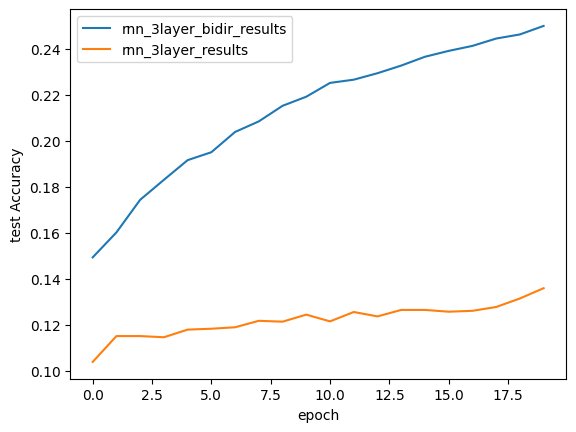

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_results,label='rnn_3layer_bidir_results')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_results, label='rnn_3layer_results')

print("This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD")
print("Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.")
print("It also seemed like the model could be even more accurate based on the graph if given more epochs")



In [40]:
#try using adam to see if model acc improves
def train_simple_network_Adamw(model, loss_func, train_loader, test_loader=None, score_funcs=None,
                         epochs=50, device="cuda", checkpoint_file=None, lr=0.0005):
    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training

    """
    to_track = ["epoch", "total time", "train loss"]
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if test_loader is not None:
            to_track.append("test " + eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    #Using Adam
    optimizer =  torch.optim.AdamW(model.parameters(), lr=0.0005)
    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch"):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["total time"].append( total_train_time )
        results["epoch"].append( epoch )

        if test_loader is not None:
            model = model.eval()
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

    if checkpoint_file is not None:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'results' : results
            }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

In [47]:
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader

# Assuming the dataset is already loaded and instantiated
train_labels = np.array(dataset.labels)  # Access the labels from the dataset

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# Convert to a tensor and move to device
device = 'cuda'
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Now use these weights in CrossEntropyLoss
loss_func = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Set other hyperparameters
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)
B = 16
D = 64

# Define the data loaders
train_loader = DataLoader(dataset, batch_size=B, shuffle=True, collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, collate_fn=pad_and_pack)

# Model definition (adjust according to your previous architecture)
rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)),  #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True),  # Reduce the output to one item (B, D)
  nn.Linear(hidden_nodes * 2, classes),  #(B, D) -> (B, classes)
)

# Move model to device
rnn_3layer_bidir.to(device)

# Train the model (assuming you have implemented the `train_simple_network_Adamw` function)
rnn_3layer_bidir_AdamW = train_simple_network_Adamw(rnn_3layer_bidir,
                                                    loss_func, train_loader,
                                                    test_loader=test_loader,
                                                    score_funcs={'Accuracy': accuracy_score},
                                                    device=device,
                                                    epochs=20,
                                                    lr=0.0005)


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

Testing:   0%|          | 0/200 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='test Accuracy'>

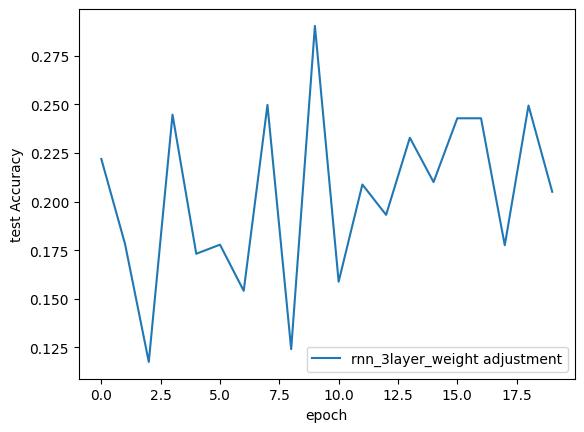

In [48]:
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_AdamW, label='rnn_3layer_weight adjustment')


<Axes: xlabel='epoch', ylabel='test Accuracy'>

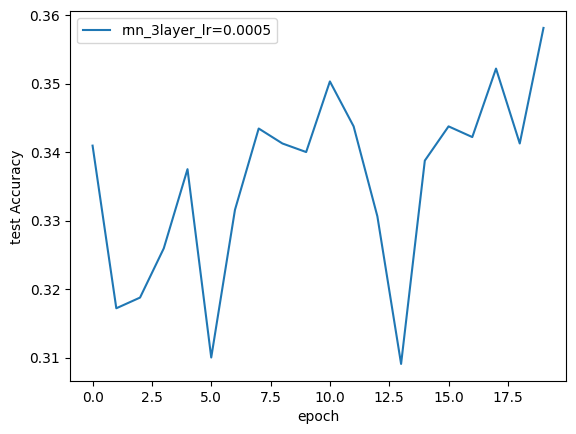

In [42]:
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_AdamW, label='rnn_3layer_lr=0.0005')


This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD
Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.
It also seemed like the model could be even more accurate based on the graph if given more epochs


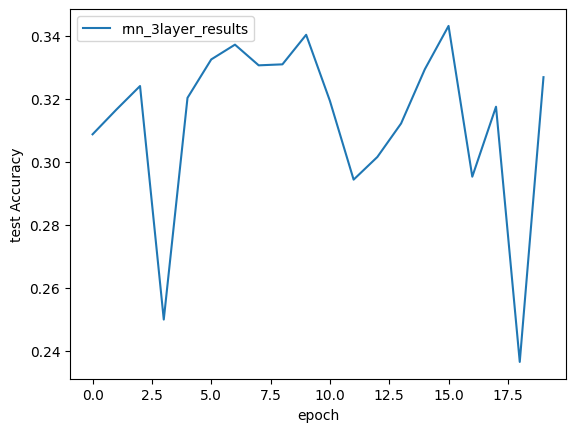

In [33]:
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_AdamW, label='rnn_3layer_results')

print("This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD")
print("Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.")
print("It also seemed like the model could be even more accurate based on the graph if given more epochs")



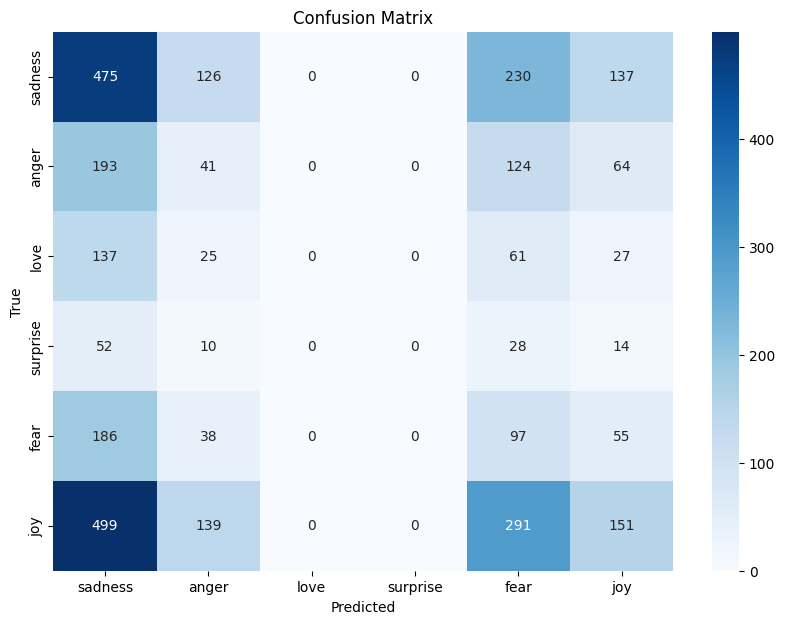

In [38]:
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to compute the confusion matrix
def plot_confusion_matrix(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation for inference
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass through the model
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class

            all_preds.extend(preds.cpu().numpy())  # Store the predictions
            all_labels.extend(labels.cpu().numpy())  # Store the true labels

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.label_names, yticklabels=dataset.label_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix after training the model
plot_confusion_matrix(rnn_3layer_bidir, test_loader, device)


<Axes: xlabel='epoch', ylabel='test Accuracy'>

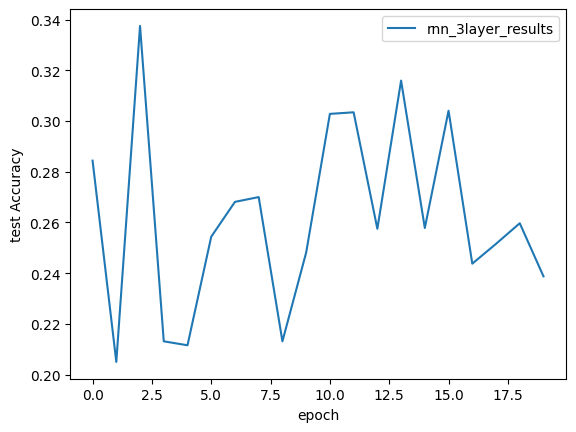

In [36]:
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_AdamW, label='rnn_3layer_results')


In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_AdamW, label='rnn_3layer_results')


In [ ]:
#For biderectional batch size = 16 number of layers =3 epoch= 40

B = 16
train_loader = DataLoader(train_data, batch_size=B, shuffle=True, \
                          collate_fn=pad_and_pack)
test_loader = DataLoader(test_data, batch_size=B, shuffle=False, \
                         collate_fn=pad_and_pack)

rnn_3layer_bidir = nn.Sequential(
  EmbeddingPackable(nn.Embedding(vocab_size, D)), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, num_layers=3, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  LastTimeStep(rnn_layers=3, bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

rnn_3layer_bidir.to(device)
rnn_3layer_bidir_AdamW_40epoch = train_simple_network(rnn_3layer_bidir, \
                                          loss_func, train_loader, \
                                            test_loader=test_loader, \
                                            score_funcs={'Accuracy': \
                                          accuracy_score}, \
                                             device=device,\
                                              epochs=40, \
                                                lr=0.01)


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

Training:   0%|          | 0/1956 [00:00<?, ?it/s]

Testing:   0%|          | 0/489 [00:00<?, ?it/s]

In [ ]:
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_results,label='rnn_3layer_bidir_results')
sns.lineplot(x='epoch', y='test Accuracy', data=rnn_3layer_bidir_AdamW, label='rnn_3layer_results')

print("This graph shows the test accuracy for each epoch for 4 different rnns with he same optimizer SGD")
print("Since RNN bidirectional gives us the best training accuracy, I decided to go with bidirectional.")
print("It also seemed like the model could be even more accurate based on the graph if given more epochs")



NameError: name 'sns' is not defined